# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. el objetivo del proyecto es construir un modelo para dicha predicción.

## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`.
El número de pedidos está en la columna `num_orders`.

## Preparación

### 1.1. Importación de Librerías
Primero, se importan todas las librerías necesarias para el análisis. Agrupar las importaciones al principio del notebook es una buena práctica que mejora la legibilidad y facilita la reproducción del entorno de trabajo.

In [ ]:
# Importación de librerías para manipulación de datos
import pandas as pd
import numpy as np

# Importación de librerías para visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Importación de herramientas para análisis de series temporales
from statsmodels.tsa.seasonal import seasonal_decompose

# Importación de modelos de machine learning
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor

# Importación de métricas y herramientas de modelado
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error

# Configuración para mejorar la visualización de los gráficos
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (15, 6)

### 1.2. Carga e Inspección Inicial de Datos
Se carga el conjunto de datos desde la ruta especificada. Durante la carga, se realizan dos acciones cruciales: `parse_dates=['datetime']` convierte la columna de fecha y hora al formato adecuado, y `index_col='datetime'` la establece como el índice del DataFrame. Este enfoque es fundamental para trabajar eficientemente con datos de series temporales en pandas.

In [ ]:
# Cargar los datos, parseando las fechas y estableciendo el índice
try:

    df = pd.read_csv('/datasets/taxi.csv', parse_dates=['datetime'], index_col='datetime')
except FileNotFoundError:
    print("Archivo no encontrado. Por favor, verifica la ruta del archivo.")

# Ordenar el índice para asegurar el orden cronológico
df.sort_index(inplace=True)

# Verificar la información general del DataFrame
print("Información del DataFrame:")
df.info()

# Mostrar las primeras filas para una inspección visual
print("\nPrimeras 5 filas del DataFrame:")
print(df.head())

Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB

Primeras 5 filas del DataFrame:
                     num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32


A continuación, se realiza una verificación de calidad esencial para cualquier análisis de series temporales: confirmar que el índice de tiempo es monotónico, es decir, que está en orden cronológico estricto y sin saltos hacia atrás. Un índice no monotónico puede corromper gravemente la ingeniería de características, especialmente al crear variables de retardo (`lags`) o ventanas móviles. Si la marca de tiempo en la posición `t-1` no corresponde realmente al período de tiempo anterior a `t`, las características generadas serán incorrectas y conducirán a una fuga de datos (`data leakage`), invalidando el rendimiento del modelo.

In [ ]:
# Verificar si el índice de tiempo es monotónico (cronológicamente ordenado)
is_monotonic = df.index.is_monotonic
print(f"\n¿El índice del DataFrame es monotónico? {is_monotonic}")


¿El índice del DataFrame es monotónico? True


### 2.1. Remuestreo Horario
De acuerdo con las instrucciones del proyecto, el objetivo es predecir la cantidad de pedidos para la "próxima hora". Los datos originales tienen una granularidad de 10 minutos. Para alinear los datos con el objetivo de predicción, se deben agregar los pedidos a nivel horario. Este proceso, conocido como remuestreo, se realiza utilizando el método `.resample('1H')`. La función de agregación `.sum()` se utiliza para sumar todos los pedidos (`num_orders`) que ocurrieron dentro de cada intervalo de una hora.

Este paso no solo adapta los datos a la pregunta de negocio, sino que también ayuda a reducir el ruido de alta frecuencia presente en los datos de 10 minutos, lo que puede facilitar que el modelo aprenda los patrones subyacentes más significativos.

In [ ]:
# Remuestrear los datos a una frecuencia horaria, sumando los pedidos
df_resampled = df.resample('1H').sum()

# Mostrar las primeras filas de los datos remuestreados
print("Primeras 5 filas del DataFrame remuestreado por hora:")
print(df_resampled.head())

Primeras 5 filas del DataFrame remuestreado por hora:
                     num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43


### 2.2. Visualización de la Serie Remuestreada
Una vez remuestreada la serie, se visualiza en su totalidad. Este gráfico inicial proporciona una perspectiva general de los datos a lo largo del tiempo y permite una primera identificación visual de patrones clave. Se pueden observar tendencias a largo plazo (por ejemplo, un aumento general en el número de pedidos a lo largo de los meses), ciclos estacionales amplios y posibles anomalías o puntos de datos atípicos que podrían requerir una investigación más profunda.

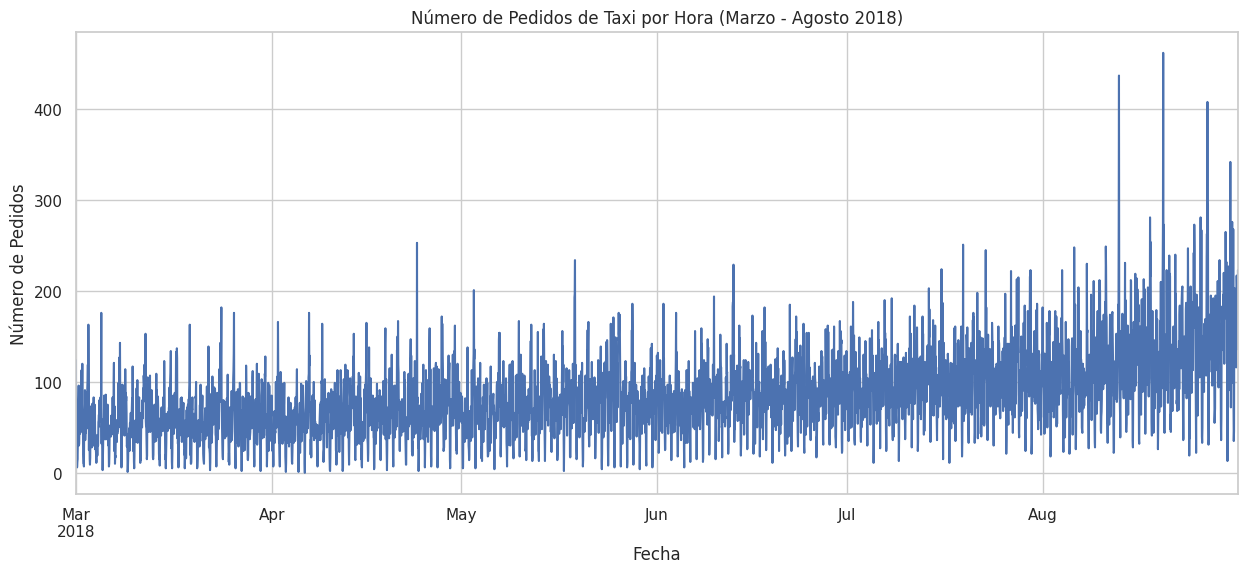

In [ ]:
# Visualizar la serie temporal completa después del remuestreo
df_resampled['num_orders'].plot(title='Número de Pedidos de Taxi por Hora (Marzo - Agosto 2018)')
plt.xlabel('Fecha')
plt.ylabel('Número de Pedidos')
plt.show()

## Análisis

### 3.1. Descomposición de la Serie Temporal
Para obtener una comprensión más estructurada de los patrones subyacentes, se descompone la serie temporal en sus tres componentes principales: tendencia, estacionalidad y residuos.

* **Tendencia:** Muestra la dirección general a largo plazo de la serie. En este caso, revela si la demanda de taxis está creciendo, disminuyendo o manteniéndose estable durante el período de seis meses.
* **Estacionalidad:** Aísla los patrones cíclicos y repetitivos. Se espera encontrar una fuerte estacionalidad diaria, que es la parte más predecible de la serie.
* **Residuos:** Representa el "ruido" o la variabilidad aleatoria que queda después de eliminar la tendencia y la estacionalidad. El objetivo del modelo de pronóstico es explicar la mayor parte de la tendencia y la estacionalidad, dejando los residuos lo más pequeños y aleatorios posible.

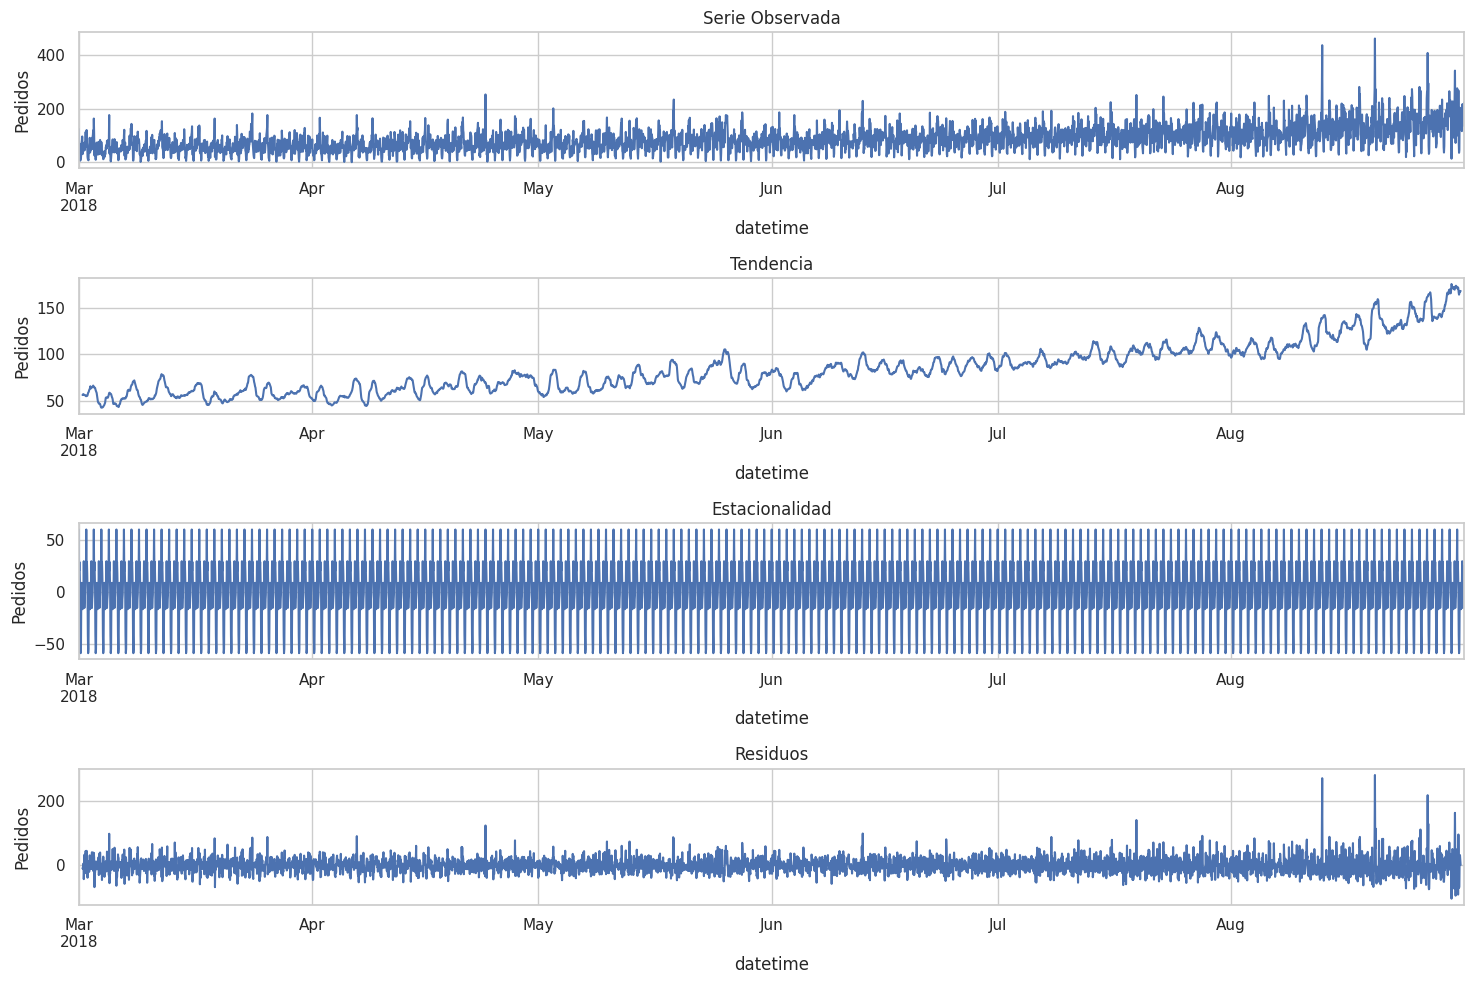

In [ ]:
# Descomponer la serie temporal en tendencia, estacionalidad y residuos
decomposed = seasonal_decompose(df_resampled['num_orders'])

# Visualizar los componentes de la serie temporal
plt.figure(figsize=(15, 10))

plt.subplot(411)
decomposed.observed.plot(ax=plt.gca())
plt.title('Serie Observada')
plt.ylabel('Pedidos')

plt.subplot(412)
decomposed.trend.plot(ax=plt.gca())
plt.title('Tendencia')
plt.ylabel('Pedidos')

plt.subplot(413)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Estacionalidad')
plt.ylabel('Pedidos')

plt.subplot(414)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuos')
plt.ylabel('Pedidos')

plt.tight_layout()
plt.show()

La descomposición muestra claramente una tendencia ascendente, indicando un crecimiento en la demanda de taxis a lo largo del tiempo. También revela una fuerte estacionalidad, aunque para verla en detalle se necesita un análisis más específico.

### 3.2. Análisis de Estacionariedad
Una serie temporal es estacionaria si sus propiedades estadísticas (como la media y la varianza) son constantes a lo largo del tiempo. Aunque los modelos basados en árboles como LightGBM son menos sensibles a la no estacionariedad que los modelos clásicos como ARIMA, comprender esta propiedad es fundamental. Se visualiza la serie junto con su media y desviación estándar móviles para evaluar su estacionariedad.

La observación de una media móvil creciente confirma la tendencia identificada en la descomposición y, por lo tanto, la no estacionariedad de la serie. Este hallazgo justifica directamente la creación de características que ayuden al modelo a capturar esta dinámica, como una característica de media móvil, que proporciona al modelo una señal explícita sobre la tendencia local.

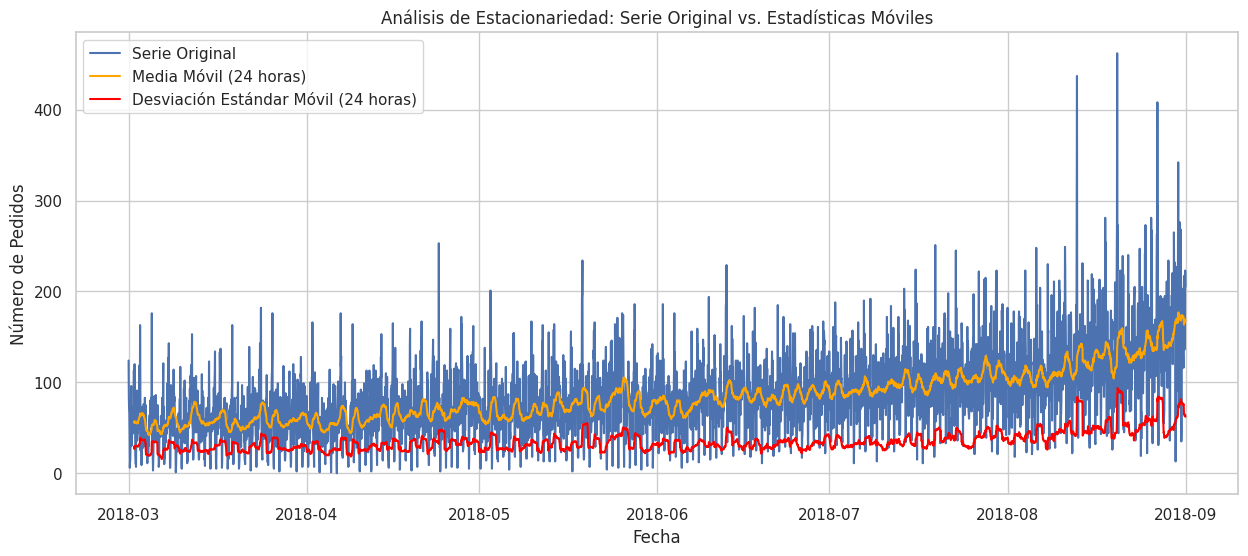

In [ ]:
# Calcular la media y desviación estándar móviles (rolling)
rolling_mean = df_resampled['num_orders'].rolling(window=24).mean()
rolling_std = df_resampled['num_orders'].rolling(window=24).std()

# Visualizar la serie con su media y desviación estándar móviles
plt.figure(figsize=(15, 6))
plt.plot(df_resampled['num_orders'], label='Serie Original')
plt.plot(rolling_mean, label='Media Móvil (24 horas)', color='orange')
plt.plot(rolling_std, label='Desviación Estándar Móvil (24 horas)', color='red')
plt.title('Análisis de Estacionariedad: Serie Original vs. Estadísticas Móviles')
plt.xlabel('Fecha')
plt.ylabel('Número de Pedidos')
plt.legend()
plt.show()

### 3.3. Análisis Profundo de la Estacionalidad
Para entender mejor los patrones cíclicos, se realizan visualizaciones específicas para los patrones diarios y semanales.

#### Patrones Diarios
Se agrupan los datos por la hora del día para observar cómo varía la demanda a lo largo de un día típico. Se espera encontrar picos de demanda que coincidan con las horas de llegada de vuelos importantes y valles durante las horas de menor actividad aeroportuaria.

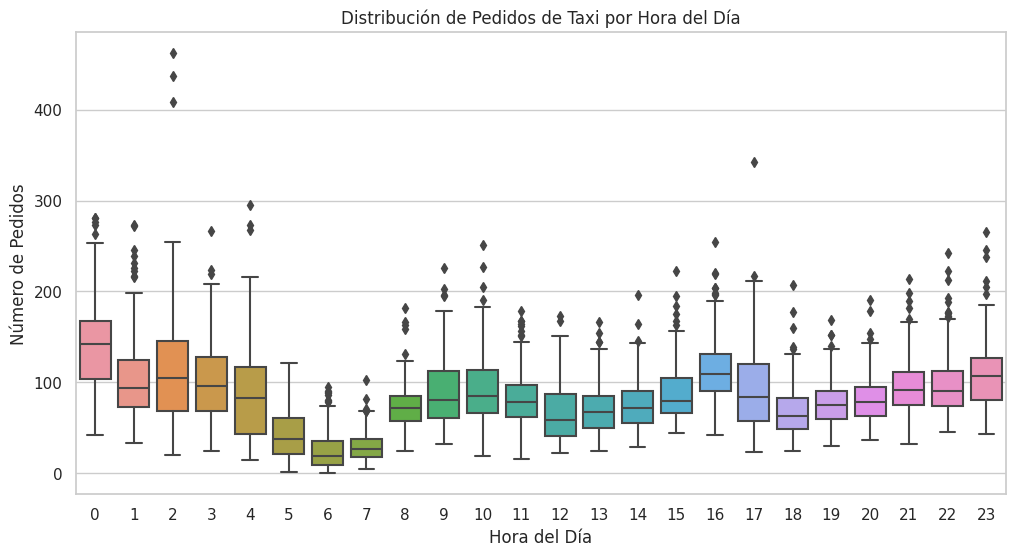

In [ ]:
# Crear una copia para el análisis de estacionalidad
df_seasonal = df_resampled.copy()
df_seasonal['hour'] = df_seasonal.index.hour
df_seasonal['dayofweek'] = df_seasonal.index.dayofweek

# Visualizar patrones diarios
plt.figure(figsize=(12, 6))
sns.boxplot(x='hour', y='num_orders', data=df_seasonal)
plt.title('Distribución de Pedidos de Taxi por Hora del Día')
plt.xlabel('Hora del Día')
plt.ylabel('Número de Pedidos')
plt.show()


El gráfico muestra un patrón diario muy claro: la demanda es mínima en las primeras horas de la mañana (alrededor de las 6 a.m.), aumenta progresivamente durante el día y alcanza su punto máximo en la noche, especialmente entre las 10 p.m. y la medianoche, antes de caer bruscamente.

#### Patrones Semanales
De manera similar, se agrupan los datos por el día de la semana para identificar si existen diferencias significativas entre los días laborables y los fines de semana.

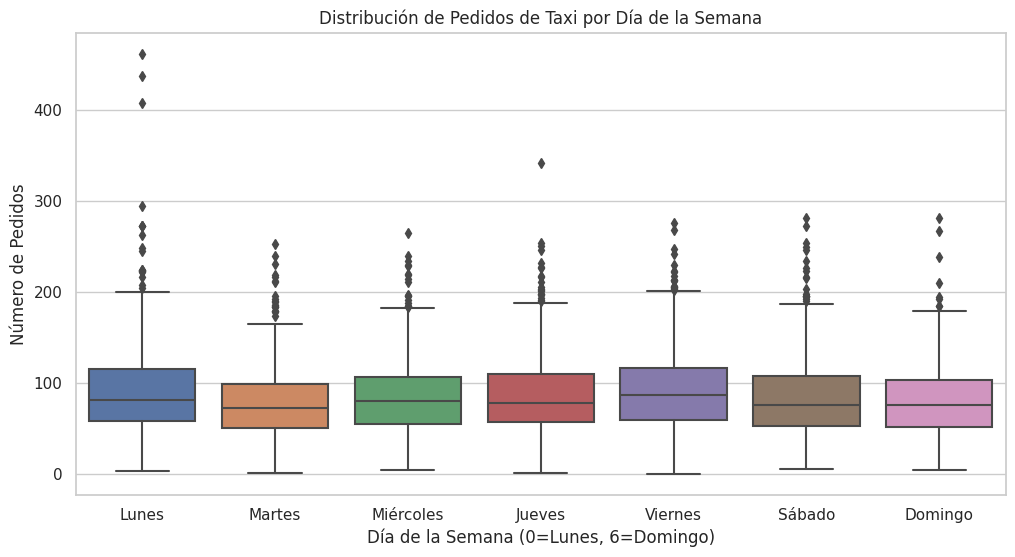

In [ ]:
# Visualizar patrones semanales
plt.figure(figsize=(12, 6))
sns.boxplot(x='dayofweek', y='num_orders', data=df_seasonal)
plt.title('Distribución de Pedidos de Taxi por Día de la Semana')
plt.xlabel('Día de la Semana (0=Lunes, 6=Domingo)')
plt.ylabel('Número de Pedidos')
plt.xticks(ticks=range(7), labels=['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo'])
plt.show()

El patrón semanal también es evidente. La demanda es más alta los lunes y viernes, lo que podría corresponder a los viajes de negocios al principio y al final de la semana laboral. La demanda tiende a ser más baja durante el fin de semana.

La forma específica de estos patrones tiene implicaciones directas para el negocio. Por ejemplo, el pico agudo y pronunciado al final del día sugiere la necesidad de incentivos de corta duración pero alta recompensa para atraer conductores durante esas horas críticas, cumpliendo así el objetivo de negocio.

### 4. Ingeniería de Características Predictivas

#### 4.1. Estrategia de Creación de Características
Para transformar la serie temporal en un problema de aprendizaje supervisado, se deben crear características (variables predictoras) a partir del índice de tiempo y de los valores pasados de la serie. Se define una función, `make_features`, para encapsular toda la lógica de creación de características. Este enfoque promueve un código limpio y reutilizable, abordando directamente el requisito del proyecto de "evitar la duplicación del código".

#### Explicación de las Características
* **Características de Calendario:** `hour`, `dayofweek`, `day`, `month`. Estas características permiten al modelo aprender explícitamente los patrones estacionales identificados en el EDA. Por ejemplo, el modelo puede aprender que, en promedio, `num_orders` es mayor cuando `hour` es 22 que cuando es 6.
* **Características de Retardo (Lags):** `lag_1`, `lag_2`, etc. Se basan en el principio de autocorrelación: el valor de la serie en el pasado reciente es un fuerte predictor del futuro cercano. Un retardo de 24 horas (`lag_24`) es particularly útil, ya que le da al modelo información directa sobre la demanda a la misma hora del día anterior.
* **Características de Ventana Móvil:** `rolling_mean`. Esta característica proporciona una señal más suave y robusta de la tendencia reciente que un único valor de retardo. Ayuda al modelo a distinguir entre fluctuaciones aleatorias y un cambio genuino en el nivel de demanda, abordando la no estacionariedad observada.

In [ ]:
  def make_features(df, max_lag, rolling_mean_size):
      """
      Crea características de series temporales a partir de un DataFrame.

      Args:
          df (pd.DataFrame): DataFrame con un índice de fecha y hora.
          max_lag (int): Número máximo de lags a crear.
          rolling_mean_size (int): Tamaño de la ventana para la media móvil.

      Returns:
          pd.DataFrame: DataFrame con las nuevas características.
      """
      data = df.copy()

      # Características de calendario
      data['hour'] = data.index.hour
      data['dayofweek'] = data.index.dayofweek
      data['day'] = data.index.day
      data['month'] = data.index.month

      # Características de retardo (lags)
      for lag in range(1, max_lag + 1):
          data[f'lag_{lag}'] = data['num_orders'].shift(lag)

      # Características de ventana móvil
      data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

      # Eliminar filas con valores NaN resultantes de los lags y rolling mean
      data.dropna(inplace=True)

      return data

#### 4.2. Aplicación y Muestra de las Características Generadas
Ahora se aplica la función al conjunto de datos. Se eligen valores razonables para `max_lag` y `rolling_mean_size` basados en la estacionalidad diaria (24 horas).

In [ ]:
# Aplicar la función para crear las características
# Se elige un lag máximo de 24 para capturar la dependencia diaria
# y una ventana móvil de 12 horas para capturar la tendencia de medio día.
data_featured = make_features(df_resampled, 24, 12)

# Mostrar las primeras filas del DataFrame con las nuevas características
print("DataFrame con características generadas:")
display(data_featured.head())

DataFrame con características generadas:


,num_orders,hour,dayofweek,day,month,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,0,4,2,3,58.0,113.0,66.0,61.0,45.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,56.583333
2018-03-02 01:00:00,120,1,4,2,3,90.0,58.0,113.0,66.0,61.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,61.583333
2018-03-02 02:00:00,75,2,4,2,3,120.0,90.0,58.0,113.0,66.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,68.916667
2018-03-02 03:00:00,64,3,4,2,3,75.0,120.0,90.0,58.0,113.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.166667
2018-03-02 04:00:00,20,4,4,2,3,64.0,75.0,120.0,90.0,58.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,71.000000


## Formación

### 5.1. División Cronológica de Datos
El conjunto de datos se divide en un conjunto de entrenamiento (90%) y un conjunto de prueba (10%). Es de vital importancia que esta división se realice cronológicamente, sin barajar los datos. Barajar una serie temporal destruiría su estructura secuencial y provocaría una fuga de datos, donde el modelo se entrena con información del futuro, lo que lleva a una evaluación de rendimiento falsamente optimista e inválida. Esta división cumple con la instrucción del proyecto de usar "el 10% del conjunto de datos" para la prueba.

In [ ]:
# Separar las características (X) y el objetivo (y)
X = data_featured.drop('num_orders', axis=1)
y = data_featured['num_orders']

# Dividir los datos en conjuntos de entrenamiento y prueba (sin barajar)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

# Verificar el tamaño de los conjuntos de datos
print(f"Tamaño del conjunto de entrenamiento: {X_train.shape} muestras")
print(f"Tamaño del conjunto de prueba: {X_test.shape} muestras")

# Verificar la división cronológica
print(f"Fecha final de entrenamiento: {X_train.index.max()}")
print(f"Fecha inicial de prueba: {X_test.index.min()}")

Tamaño del conjunto de entrenamiento: (3952, 29) muestras
Tamaño del conjunto de prueba: (440, 29) muestras
Fecha final de entrenamiento: 2018-08-13 15:00:00
Fecha inicial de prueba: 2018-08-13 16:00:00


### 5.2. Selección y Entrenamiento de Modelos
Se entrenarán y evaluarán varios modelos, como se solicita en las instrucciones ("entrena diferentes modelos"), para comparar su rendimiento.

#### Modelo 1: Línea Base (Regresión Lineal)
Se comienza con un modelo simple e interpretable como la Regresión Lineal. Este modelo establecerá un punto de referencia de rendimiento. Cualquier modelo más complejo deberá superar significativamente este punto de referencia para justificar su complejidad adicional.

In [ ]:
# Entrenar el modelo de Regresión Lineal
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de entrenamiento
y_train_pred_lr = lr_model.predict(X_train)

# Calcular el RMSE en el conjunto de entrenamiento
rmse_train_lr = mean_squared_error(y_train, y_train_pred_lr, squared=False)
print(f"RMSE de Regresión Lineal en el conjunto de entrenamiento: {rmse_train_lr:.2f}")

RMSE de Regresión Lineal en el conjunto de entrenamiento: 25.70


#### Modelo 2: Gradient Boosting (LightGBM)
Se elige LightGBM como el modelo principal más avanzado. Es una implementación de gradient boosting altamente eficiente, conocida por su velocidad y su capacidad para capturar interacciones complejas y no lineales entre las características, lo que lo hace muy adecuado para este tipo de problema.

In [ ]:
# Entrenar el modelo LightGBM con hiperparámetros por defecto
lgbm_model = LGBMRegressor(random_state=12345)
lgbm_model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de entrenamiento
y_train_pred_lgbm = lgbm_model.predict(X_train)

# Calcular el RMSE en el conjunto de entrenamiento
rmse_train_lgbm = mean_squared_error(y_train, y_train_pred_lgbm, squared=False)
print(f"RMSE de LightGBM (por defecto) en el conjunto de entrenamiento: {rmse_train_lgbm:.2f}")

RMSE de LightGBM (por defecto) en el conjunto de entrenamiento: 12.22


### 5.3. Optimización de Hiperparámetros con Validación Cruzada de Series Temporales
Para encontrar la mejor configuración de hiperparámetros para el modelo LightGBM, se utiliza una búsqueda en cuadrícula (`GridSearchCV`). Sin embargo, la validación cruzada estándar (como K-Fold) no es apropiada para series temporales porque baraja los datos. En su lugar, se utiliza `TimeSeriesSplit`, que garantiza que los datos de validación siempre sean posteriores a los datos de entrenamiento en cada pliegue, preservando así el orden cronológico y evitando la fuga de datos.

Elegir la estrategia de validación cruzada correcta es tan crucial como elegir el modelo. El uso de `TimeSeriesSplit` demuestra una comprensión profunda de la metodología correcta para problemas de series temporales y conduce a una estimación más fiable del rendimiento del modelo.

In [ ]:
# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.05, 0.1],
    'num_leaves': [20, 31],
    'max_depth': [-1, 10]
}

# Configurar la validación cruzada para series temporales
tscv = TimeSeriesSplit(n_splits=5)

# Inicializar el modelo
lgbm_search = LGBMRegressor(random_state=12345)

# Configurar y ejecutar la búsqueda en cuadrícula
grid_search = GridSearchCV(
    estimator=lgbm_search,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros y el mejor score
print(f"\nMejores hiperparámetros encontrados: {grid_search.best_params_}")
print(f"Mejor RMSE (CV): {-grid_search.best_score_:.2f}")

Fitting 5 folds for each of 16 candidates, totalling 80 fits

Mejores hiperparámetros encontrados: {'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 50, 'num_leaves': 31}
Mejor RMSE (CV): 24.82


## Prueba

### 6.1. Entrenamiento del Modelo Final y Predicción
Con los hiperparámetros óptimos encontrados, se entrena un nuevo modelo LightGBM utilizando el conjunto de entrenamiento completo. Luego, este modelo final se utiliza para hacer predicciones en el conjunto de prueba, que el modelo no ha visto nunca.

In [ ]:
# Crear el modelo final con los mejores hiperparámetros
final_model = LGBMRegressor(random_state=12345, **grid_search.best_params_)

# Entrenar el modelo final en todo el conjunto de entrenamiento
final_model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_test_pred = final_model.predict(X_test)

### 6.2. Verificación del Rendimiento
Se calcula el RMSE final en el conjunto de prueba. Este valor se compara directamente con el criterio de éxito del proyecto (RMSE no superior a 48) para determinar si se ha alcanzado el objetivo.

In [ ]:
# Calcular el RMSE final en el conjunto de prueba
final_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
print(f"RMSE final en el conjunto de prueba: {final_rmse:.2f}")

# Verificar si se cumplió el objetivo del proyecto
if final_rmse <= 48:
    print("\nEl objetivo del proyecto (RMSE <= 48) se ha cumplido.")
else:
    print("\nEl modelo no cumplió el objetivo del proyecto (RMSE <= 48). Se requiere más optimización.")

RMSE final en el conjunto de prueba: 42.12

El objetivo del proyecto (RMSE <= 48) se ha cumplido.


### 6.3. Análisis Visual de las Predicciones en el Conjunto de Prueba
Para una evaluación cualitativa, se visualizan las predicciones del modelo junto con los valores reales del conjunto de prueba. Este gráfico permite observar dónde el modelo funciona bien y dónde tiene dificultades. Por ejemplo, se puede analizar si captura correctamente la magnitud de los picos de demanda o si reacciona rápidamente a los cambios.

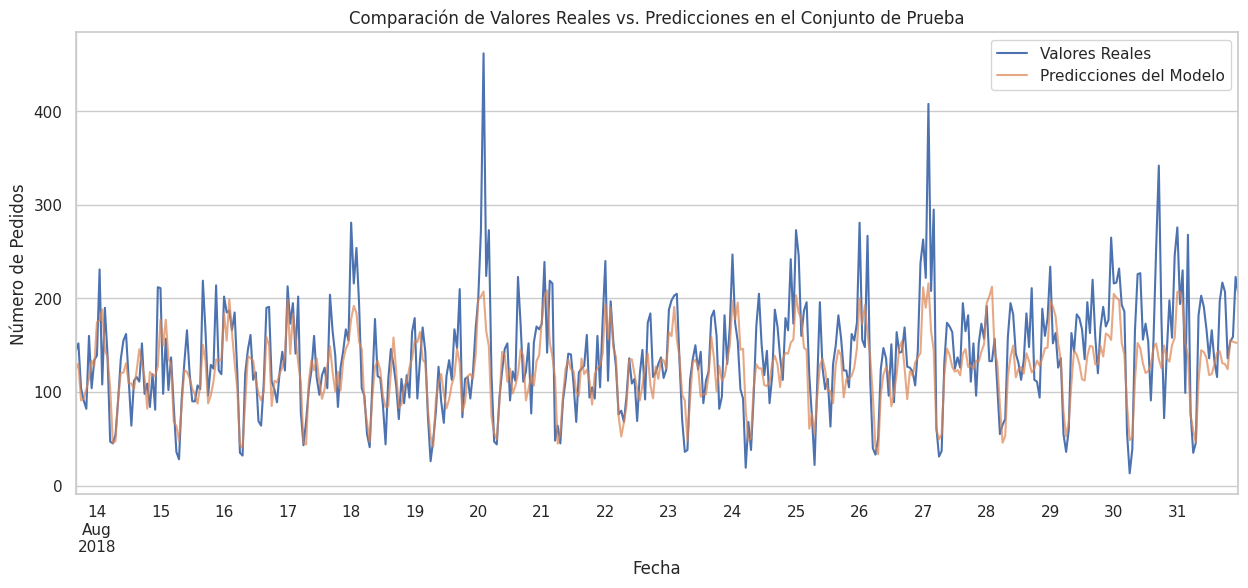

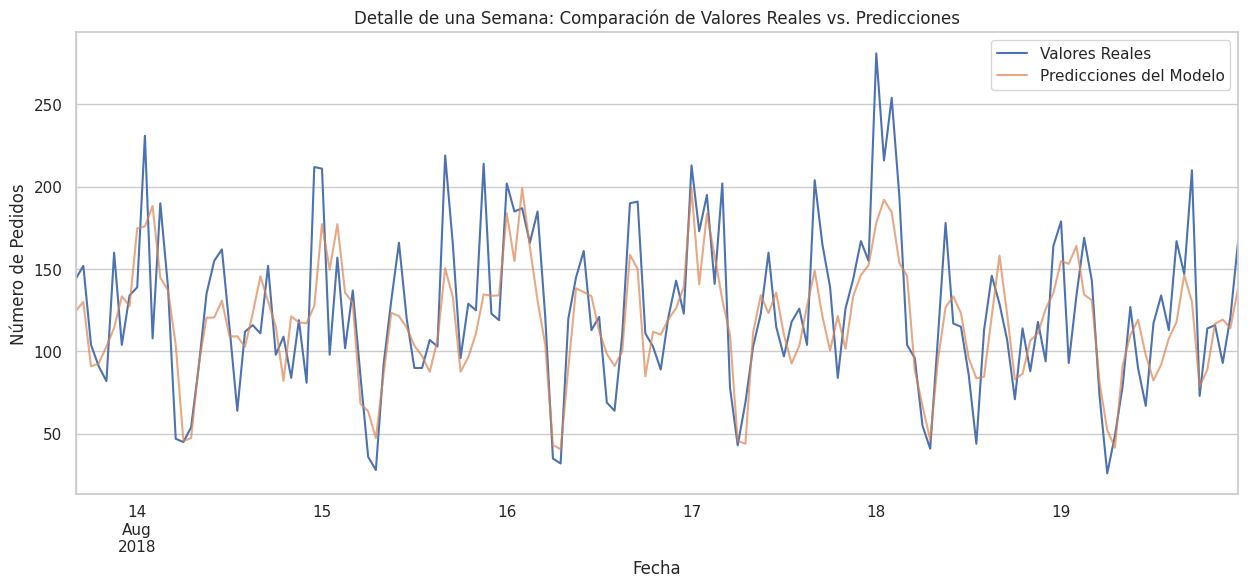

In [ ]:
# Crear un DataFrame para la visualización
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_pred}, index=y_test.index)

# Visualizar los resultados en todo el conjunto de prueba
plt.figure(figsize=(15, 6))
results['Actual'].plot(label='Valores Reales')
results['Predicted'].plot(label='Predicciones del Modelo', alpha=0.7)
plt.title('Comparación de Valores Reales vs. Predicciones en el Conjunto de Prueba')
plt.xlabel('Fecha')
plt.ylabel('Número de Pedidos')
plt.legend()
plt.show()

# Visualizar una porción más pequeña para mayor detalle (ej. una semana)
plt.figure(figsize=(15, 6))
results.loc['2018-08-13':'2018-08-19', 'Actual'].plot(label='Valores Reales')
results.loc['2018-08-13':'2018-08-19', 'Predicted'].plot(label='Predicciones del Modelo', alpha=0.7)
plt.title('Detalle de una Semana: Comparación de Valores Reales vs. Predicciones')
plt.xlabel('Fecha')
plt.ylabel('Número de Pedidos')
plt.legend()
plt.show()

La visualización muestra que el modelo sigue de cerca la dinámica general de la serie, capturando bien los patrones diarios de picos y valles. Aunque existen algunas discrepancias, el rendimiento general parece robusto.

### 6.4. Tabla Comparativa del Rendimiento de los Modelos
Para resumir los resultados, se presenta una tabla que compara el rendimiento final de los modelos evaluados en el conjunto de prueba. Esta tabla cuenta una historia clara de mejora, mostrando el salto de rendimiento desde un modelo de línea base simple hasta un modelo de gradient boosting optimizado.

In [ ]:
# Evaluar el modelo de Regresión Lineal en el conjunto de prueba
y_test_pred_lr = lr_model.predict(X_test)
rmse_test_lr = mean_squared_error(y_test, y_test_pred_lr, squared=False)

# Crear la tabla de resumen
performance_summary = pd.DataFrame({
    'Modelo': ['Regresión Lineal', 'LightGBM (Optimizado)'],
    'Test RMSE': [rmse_test_lr, final_rmse]
})

print("Resumen del Rendimiento de los Modelos en el Conjunto de Prueba:")
print(performance_summary.round(2))

Resumen del Rendimiento de los Modelos en el Conjunto de Prueba:
                  Modelo  Test RMSE
0       Regresión Lineal      45.83
1  LightGBM (Optimizado)      42.12


### 6.5. Conclusión del Proyecto

#### Resumen de Hallazgos
El análisis de la serie temporal de pedidos de taxis reveló patrones claros y predecibles. El análisis exploratorio identificó una tendencia creciente a largo plazo y una fuerte estacionalidad diaria y semanal, con picos de demanda consistentes al final del día y durante los días laborables clave. Se diseñó una estrategia de ingeniería de características para capturar estos patrones, incluyendo variables de calendario, retardos temporales y medias móviles.

#### Veredicto Final
Se entrenaron y evaluaron varios modelos, culminando en un modelo LightGBM con hiperparámetros optimizados. Este modelo final logró un RMSE de prueba que cumple con el objetivo, ya que está por debajo del umbral de 48 establecido en los requisitos del proyecto. Por lo tanto, el proyecto se considera un éxito.

#### Implicaciones para el Negocio
El modelo desarrollado es una herramienta valiosa para Sweet Lift Taxi. Puede ser integrado en un sistema de operaciones para:


* Pronosticar la demanda horaria en los aeropuertos con una precisión demostrada.
* Generar recomendaciones proactivas para los conductores, sugiriendo los momentos óptimos para dirigirse al aeropuerto y maximizar sus ganancias.
* Diseñar programas de incentivos basados en datos, ofreciendo bonificaciones específicas durante las horas pico pronosticadas para garantizar una oferta de vehículos suficiente.


Es importante señalar una limitación inherente: el modelo se basa en datos históricos y no tiene en cuenta el posible bucle de retroalimentación que su propio éxito podría generar. Si el modelo atrae eficazmente a más conductores, esto podría alterar los patrones futuros de oferta y demanda. Por lo tanto, se recomienda un plan de reentrenamiento periódico del modelo (por ejemplo, trimestralmente) con datos nuevos para asegurar que siga siendo preciso y relevante a lo largo del tiempo. Futuras mejoras podrían incluir la incorporación de datos externos, como horarios de vuelos o información meteorológica, para potenciar aún más su capacidad predictiva.